In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from datetime import datetime

In [2]:
import os
path = os.listdir('/content/drive/MyDrive/comma_ai_dev/population_data')
file_list = [file for file in path if file.endswith('.csv')] # 파일명이 .csv로 끝나는 파일들 병합
file_list.sort()

In [3]:
cd /content/drive/MyDrive/comma_ai_dev/population_data

/content/drive/MyDrive/comma_ai_dev/population_data


In [4]:
df1 = pd.DataFrame()
for i in file_list:
    data = pd.read_csv(i)
    df1 = pd.concat([df1,data])  #읽어온 파일들을 하나의 df에 통합
    print(i)

LOCAL_PEOPLE_DONG_202207.csv
LOCAL_PEOPLE_DONG_202208.csv
LOCAL_PEOPLE_DONG_202209.csv
LOCAL_PEOPLE_DONG_202210.csv
LOCAL_PEOPLE_DONG_202211.csv
LOCAL_PEOPLE_DONG_202212.csv
LOCAL_PEOPLE_DONG_202301.csv
LOCAL_PEOPLE_DONG_202302.csv
LOCAL_PEOPLE_DONG_202303.csv
LOCAL_PEOPLE_DONG_202304.csv
LOCAL_PEOPLE_DONG_202305.csv
LOCAL_PEOPLE_DONG_202306.csv


In [5]:
df = df1[df1['행정동코드']==11140570]  #필동 데이터만 이용

In [6]:
#'날짜'와 '시간'을 합쳐 datetime 열로 통합
df['Datetime'] = pd.to_datetime(df['기준일ID'].astype(str)+df['시간대구분'].astype(str).str.zfill(2), format='%Y%m%d%H')
df.head()

<ipython-input-6-348f075ba335>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Datetime'] = pd.to_datetime(df['기준일ID'].astype(str)+df['시간대구분'].astype(str).str.zfill(2), format='%Y%m%d%H')


,기준일ID,시간대구분,행정동코드,총생활인구수,Datetime
90,20220701,0,11140570,7327.6609,2022-07-01 00:00:00
534,20220701,1,11140570,7286.3487,2022-07-01 01:00:00
984,20220701,2,11140570,7223.8357,2022-07-01 02:00:00
1528,20220701,3,11140570,7184.5041,2022-07-01 03:00:00
2006,20220701,4,11140570,7228.8128,2022-07-01 04:00:00


In [7]:
df = df.set_index('Datetime')
df.drop('기준일ID', axis=1,inplace=True)
df.drop('시간대구분', axis=1, inplace=True)
df.drop('행정동코드', axis=1, inplace = True) #해당 열들을 지우고 나면 datetime을 다시 지정해줘야 함
df.columns=['population'] #칼럼명 population
df.index.freq = 'H' #index 단위를 시간 단위로 지정
df.head()

,population
Datetime,
2022-07-01 00:00:00,7327.6609
2022-07-01 01:00:00,7286.3487
2022-07-01 02:00:00,7223.8357
2022-07-01 03:00:00,7184.5041
2022-07-01 04:00:00,7228.8128


In [8]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2022-07-01 00:00:00 to 2023-06-30 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   population  8760 non-null   float64
dtypes: float64(1)
memory usage: 136.9 KB


,population
count,8760.000000
mean,12624.972431
std,6064.311861
min,5050.768400
25%,7824.372675
50%,9953.738250
75%,17090.993075
max,29654.163200


<Axes: xlabel='Datetime'>

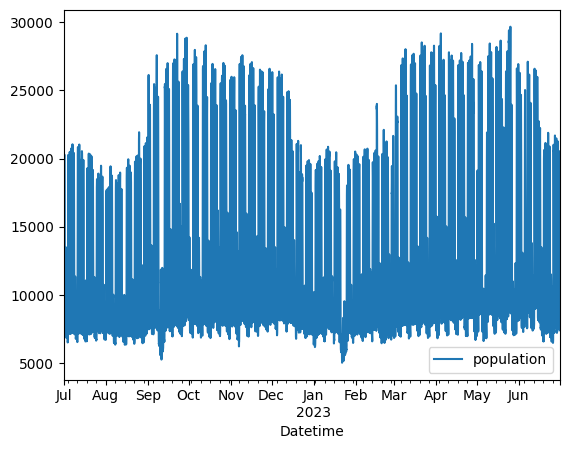

In [9]:
df.plot()

In [10]:
df.describe()

,population
count,8760.000000
mean,12624.972431
std,6064.311861
min,5050.768400
25%,7824.372675
50%,9953.738250
75%,17090.993075
max,29654.163200


In [11]:
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [12]:
train = df.iloc[:-720]  #test 데이터셋:8040
test = df.iloc[-720:] #train 데이터셋: 720 (한달치 data)

In [13]:
 #데이터 scaling
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [14]:
n_input = 168 #timestamp의 길이(한 달의 데이터)
n_features = 1

generator = TimeseriesGenerator(scaled_train, scaled_train,length=n_input,batch_size=32)

In [15]:
scaled_train.shape

(8040, 1)

In [22]:
model = Sequential()

model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(n_input,n_features))) #first layer
model.add(Dropout(0.3))

model.add(LSTM(units = 64)) #second layer
model.add(Dropout(0.3))

model.add(Dense(1)) #output layer

model.compile(optimizer='adam', loss='mse')

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 168, 128)          66560     
                                                                 
 dropout_2 (Dropout)         (None, 168, 128)          0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [25]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss', patience=5)
model.fit(generator, epochs=40, callbacks=[early_stopping])

Epoch 1/40
246/246 [==============================] - 82s 333ms/step - loss: 0.0054
Epoch 2/40
246/246 [==============================] - 80s 326ms/step - loss: 0.0047
Epoch 3/40
246/246 [==============================] - 81s 327ms/step - loss: 0.0041
Epoch 4/40
246/246 [==============================] - 81s 327ms/step - loss: 0.0037
Epoch 5/40
246/246 [==============================] - 82s 333ms/step - loss: 0.0035
Epoch 6/40
246/246 [==============================] - 81s 328ms/step - loss: 0.0031
Epoch 7/40
246/246 [==============================] - 80s 324ms/step - loss: 0.0030
Epoch 8/40
246/246 [==============================] - 79s 319ms/step - loss: 0.0027
Epoch 9/40
246/246 [==============================] - 79s 319ms/step - loss: 0.0028
Epoch 10/40
246/246 [==============================] - 80s 327ms/step - loss: 0.0024
Epoch 11/40
246/246 [==============================] - 81s 328ms/step - loss: 0.0023
Epoch 12/40
246/246 [==============================] - 80s 324ms/step - lo

In [28]:
import matplotlib.pyplot as plt
myloss = model.history.history['loss']
plt.plot(range(len(myloss)), model.history.history['loss'])

KeyError: ignored

In [29]:
#hodling my predictions
test_predictions = [] #예측 결과를 저장하기 위한 빈 배열

#numpy 배열이 올바른 차원임을 확인
#first_eval_batch = train 데이터 셋의 마지막 n_input 포인트
first_eval_batch = scaled_train[-n_input:]

#RNN에 맞춰 timeseriesgenerator 출력 형식으로 형 변환
current_batch = first_eval_batch.reshape((1,n_input,n_features))

#예측할 범위 지정(test 데이터 길이만큼 예측)
for i in range(720):
  #마지막 포인트보다 한 시점 앞선 current_batch를 전달하고 예측
  current_pred = model.predict(current_batch)[0] #예측 결과값을 2차원->1차원 변환

  #예측값을 저장
  test_predictions.append(current_pred) #예측한 결과를 하나씩 추가

  #현재 batch가 예측값을 저장하도록 업데이트
  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)
  #포인트를 하나씩 뒤로 밀어가면서 새로운 예측값 저장'''

1/1 [==============================] - 0s 46ms/step


In [30]:
true_predictions = scaler.inverse_transform(test_predictions)

In [33]:
test['prediction'] = true_predictions

<ipython-input-33-12737e63aef4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = true_predictions


<Axes: xlabel='Datetime'>

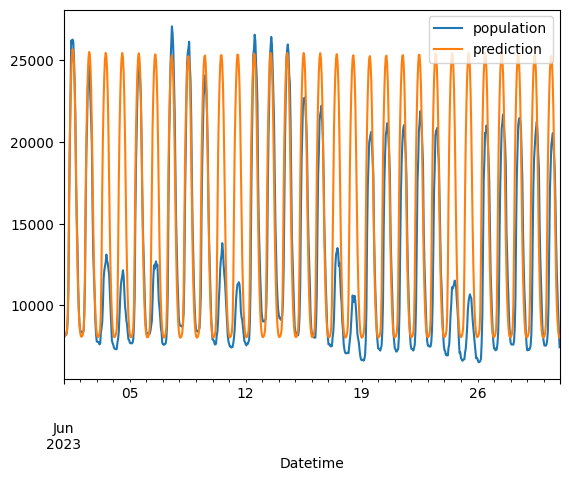

In [34]:
test.plot()

In [40]:
from keras.models import load_model
model.save("population_predict.h5")

In [38]:
cd ..

/content/drive/MyDrive/comma_ai_dev
